In [1]:
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import numpy as np
from scipy.stats import bootstrap

In [2]:
sns.set_theme(style="darkgrid",
             palette="pastel",
             font_scale=2,
             rc={'figure.figsize': (16, 9)})

In [3]:
data = pd.read_csv('Проект_1_Задание_2.csv', sep=';')

## Первичный анализ данных

In [4]:
data

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


In [5]:
data.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [6]:
data.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [7]:
data.user_id.nunique() == data.shape[0]

True

In [8]:
data.query('testgroup == "a"').user_id.nunique()

202103

In [9]:
data.query('testgroup == "b"').user_id.nunique()

202667

## Найдем ключевые параметры (конверсию, ARPU, ARPPU)

In [10]:
control = data.query('testgroup == "a"')

In [11]:
control

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a
...,...,...,...
404760,404761,0,a
404762,404763,0,a
404765,404766,0,a
404767,404768,231,a


In [12]:
test = data.query('testgroup == "b"')

In [13]:
control_conversion = control.query('revenue > 0').user_id.nunique() / control.user_id.nunique()

In [14]:
control_conversion

0.009539690157988749

In [15]:
test_conversion = test.query('revenue > 0').user_id.nunique() / test.user_id.nunique()

In [16]:
test_conversion

0.008906235351586593

In [17]:
count_revenue_users_control = control.query('revenue > 0').user_id.nunique()

In [18]:
test_revenue_users_control = test.query('revenue > 0').user_id.nunique()

In [19]:
test_revenue_users_control

1805

In [20]:
controlARPU = control.revenue.sum() / control.user_id.nunique() 

In [21]:
controlARPU

25.413719736965806

In [22]:
testARPU = test.revenue.sum() / test.user_id.nunique()

In [23]:
testARPU

26.75128659327863

In [24]:
controlARPPU = control.revenue.sum() / control.query('revenue > 0').user_id.nunique()

In [25]:
controlARPPU

2663.9984439834025

In [26]:
testARPPU = test.revenue.sum() / test.query('revenue > 0').user_id.nunique()

In [27]:
testARPPU

3003.6581717451522

## Приступим к анализу
Для начала визуализируем то, что у нас есть, чтобы правильно подобрать тест

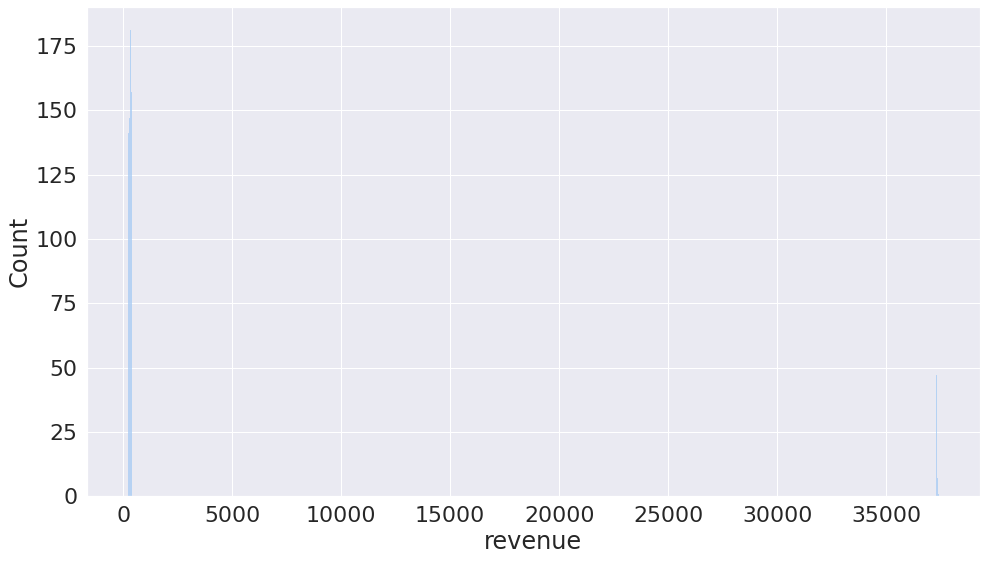

In [28]:
sns.histplot(data=control.query('revenue > 0'), x='revenue')

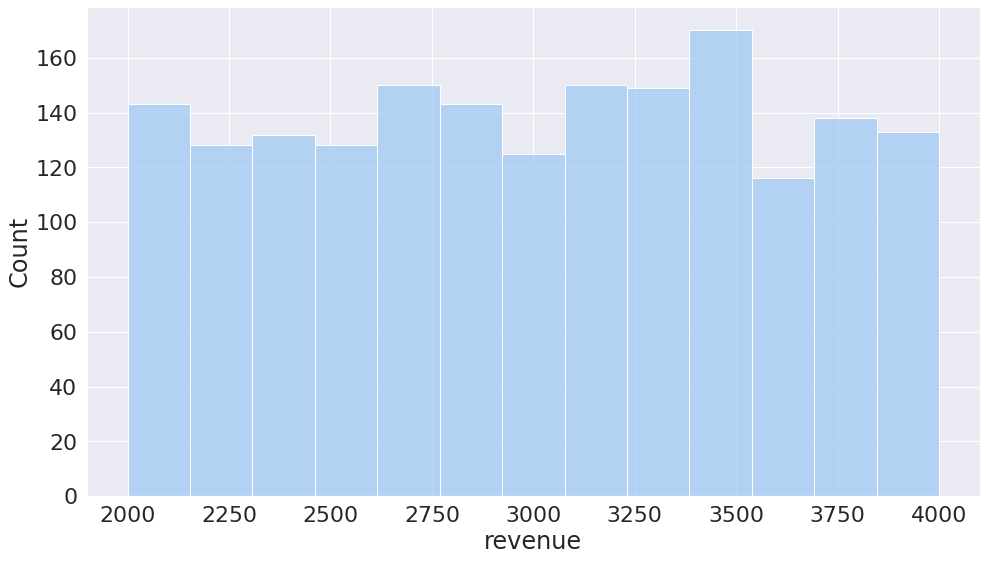

In [29]:
sns.histplot(data=test.query('revenue > 0'), x='revenue')

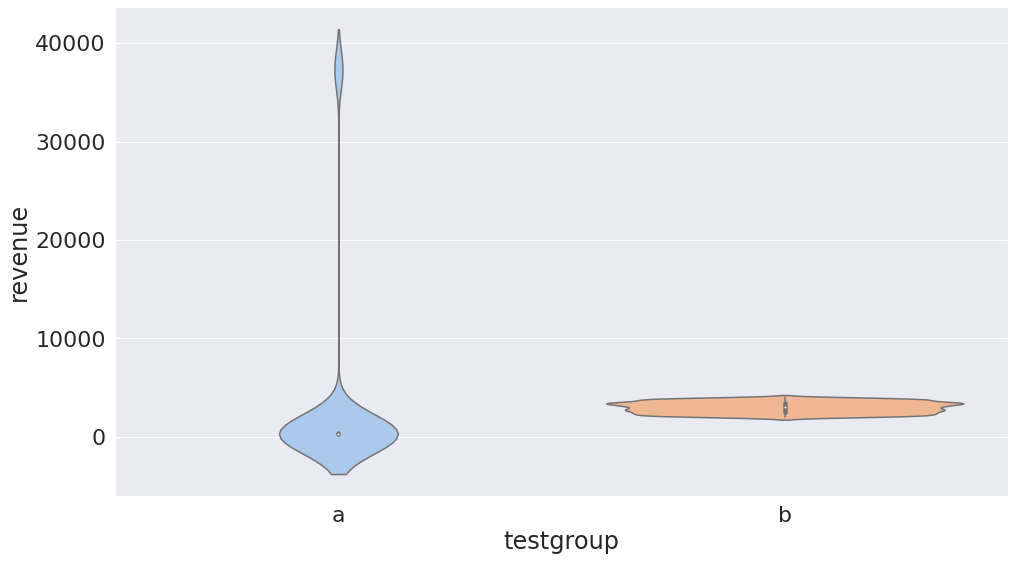

In [30]:
sns.violinplot(data=data.query('revenue > 0'), x='testgroup', y='revenue')

По графикам видно, что тестовая группа распределена относительно нормально,  
а в контрольной группе есть сильные выбросы, то есть пользователи либо тратят очень много, либо очень мало.   
В тестовой же группе все пользователи тратят примерно одни и те же суммы.  

Для начала можем провести тест Хи-квадрат по двум категориальным переменным:  
1) покупает ли пользователь акционные наборы;  
2) группа  

H0 - доля покупающих не зависит от группы  
H1 - доля покупающих зависит от группы  
p-value - 0.05  

Составим таблицу сопряженности

[ платящие пользователи группы А, неплатящие пользователи группы А ]  
[ платящие пользователи группы Б, неплатящие пользователи группы Б ]

In [31]:
pay_a = control.query('revenue > 0').user_id.nunique()

In [32]:
pay_b = test.query('revenue > 0').user_id.nunique()

In [33]:
not_pay_a = control.user_id.nunique() - control.query('revenue > 0').user_id.nunique()

In [34]:
not_pay_b = test.user_id.nunique() - test.query('revenue > 0').user_id.nunique()

In [35]:
chi_table = [ [pay_a, not_pay_a], [pay_b, not_pay_b] ]

In [36]:
ss.chi2_contingency(chi_table)

(4.374729521260405,
 0.03647561892312613,
 1,
 array([[  1863.89924896, 200239.10075104],
        [  1869.10075104, 200797.89924896]]))

Получили p-value < 0.05, значит различия в данных являются статистически значимыми

Далее воспользуемся методом bootstrap

In [83]:
mean_diff = []

In [85]:
for i in range(10000):
    sample_control = control.sample(frac=1, replace=True)
    sample_test = test.sample(frac=1, replace=True)
    
    mean_control = sample_control.revenue.mean()
    mean_test = sample_test.revenue.mean()
    
    sample_mean_diff = mean_control - mean_test
    mean_diff.append(sample_mean_diff)

In [86]:
len(mean_diff)

11000

In [87]:
pd.Series(median_diff).quantile(0.975)

2.876723803973942

In [88]:
pd.Series(median_diff).quantile(0.025)

-5.533952199477823

Отрезок доверительных интервалов включает в себя 0 (разница средних близится к нулю), поэтому считаем результаты этого теста статистически не значимыми.

Попробуем воспользоваться тем же методом, но теперь только для платящих пользователей

In [64]:
pay_mean_diff = []

In [77]:
for i in range(10000):
    sample_pay_control = control.query('revenue > 0').sample(frac=1, replace=True)
    sample_pay_test = test.query('revenue > 0').sample(frac=1, replace=True)
    
    mean_pay_control = sample_pay_control.revenue.mean()
    mean_pay_test = sample_pay_test.revenue.mean()
    
    sample_mean_diff_pay = mean_pay_control - mean_pay_test
    pay_mean_diff.append(sample_mean_diff_pay)

In [78]:
len(pay_mean_diff)

10000

In [80]:
pd.Series(pay_mean_diff).quantile(0.975)

71.55181549637378

In [81]:
pd.Series(median_diff).quantile(0.025)

-5.533952199477823

Аналогично с предыдущим этапом, мы не можем отклонить теорию о статистически важных различиях в группах

## Выводы
Многое можно сказать только по визуализации - исходя из графика покупок пользователей в контрольной группы, мы видим, что в контрольной группе пользователи покупали либо слишком много, либо слишком мало. Вероятно, существовали два типа товаров: средние по стоимости позиции и полноценные наборы, включавшие в себя кучу позиций. 
В тестовой группе мы видим картину, когда все пользователи стали покупать примерно то же самое. Это значит, что, вероятно, акционное предложение стало выгоднее полноценных наборов. Аналогично и для тех, кто покупал средние позиции - в акционном наборе было больше позиций, либо была дорогая позиция, на которую сильно снизили стоимость, поэтому для них это тоже стало более выгодным вариантом (лучше немного доплатить и получить намного больше).

Критерий Хи-квадрат показал статистически важные различия, причем преимущество будет у той группы, у которой больше конверсия. Согласно нашим подсчетам, конверсия в контрольной группе составила 0,009540, а в тестовой группе - 0,008906. А метод bootstrap не дал нам статистически важные различия.

Из совокупности этих предложений можно сделать вывод, что в контрольной группе результаты немного лучше.

